In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 1200 
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])
unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
funlensedTT = lambda L:np.exp(funlensedTT_log(L))


L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK_log = interp1d(L, np.log(rawKK), kind='linear', bounds_error=False, fill_value=0.)
fKK = lambda L:np.exp(fKK_log(L))


L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
flensedTT = lambda L:np.exp(flensedTT_log(L))


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)
with open('f_aniso_ftot.pkl', 'rb') as f:
    ftot = pickle.load(f)
    
print('loaded estimated ftot')

L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT_log = interp1d(L, np.log(cTgradT), kind='linear', bounds_error=False, fill_value=0.)
fTgradT = lambda L:np.exp(fTgradT_log(L))

../data/input/universe_Planck15/camb/CAMB_outputs.pkl
loaded estimated ftot


In [7]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
# cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)
cmb.fCtotal = ftot # no longer reinterpolating since it seems like it leads to errors?

In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [107]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key != 'totalF_1'):
            continue
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


totalF_1 (500, 1200, 601)


In [10]:
nBins=51

In [11]:
data = {}
ps_data = {}
# pbar = trange(len(pairs))
pairs = [[-1, -1]]
for file_idx in trange(1,51):
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        c_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/estimators_FILE%d_pair_%d_%d_aniso_noise.pkl'%(file_idx, pair[0], pair[1])
        if(not os.path.isfile(c_fname)):
            continue
        f = open(c_fname, 'rb')  
        c_data = pickle.load(f)
        f.close()       
        for key in c_data:
            if(key not in data.keys()):
                data[key] = np.array(c_data[key])
            else:
                data[key] = np.vstack((data[key], np.array(c_data[key])))  
#             print(np.shape(data[key]))

100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


In [12]:
for key in data:
    print(key, np.shape(data[key]))

-1-1 (500, 1200, 601)
-1-1_sqrtN (500, 1200, 601)


In [13]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [128]:
ps_data = {}
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_1200x1200_20x20_aniso_noise.pkl', 'rb') 
mean_field = pickle.load(f)
f.close()

In [129]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:19<00:00, 25.36it/s]

(500, 3, 50)


In [130]:
#estimate <QE QE>
ck = 'QEQE MFS'
for data_idx in trange(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:20<00:00, 23.88it/s]

(500, 3, 50)


In [131]:
#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:17<00:00, 27.80it/s]

(500, 3, 50)


In [134]:
#estimate RDN0
ck = 'RDN(0)'


for d_idx in trange(len(data['-1-1_sqrtN'])):
    RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d-aniso.pkl'%(d_idx, nBins)
    tot = None
    with open(RDN0_fname,"rb") as f:
        tot = pickle.load(f)
    
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([tot])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([tot])))  
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:09<00:00, 55.37it/s]

(500, 3, 50)


In [155]:
labels={
    'N0':r'$N^{(0)}$',
    'GRF':r'$\hat N$ on GRF',
    'kT': r'$\left<\kappa\kappa\right>$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'kkT':r'$\left<\hat\kappa\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'RDN(0)':r'${\rm RDN}^{(0)}$',
    'RDN(0)o2':r'${\rm RDN}^{(0)}$',
    'QEQE MFS':r'$\left<\hat\kappa\hat\kappa\right>$ [MFS]',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'QEQE-Nhat MFS':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$ [MFS]',
    'QEQE-ra4*Nhat':r'$\left<\hat\kappa\hat\kappa\right>-r\hat N$',
    'QEQE-ra4*Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-rN_{\rm theory}$',
#     'QEQE-RDN(0)':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$  [50$s$, 50$s'$]",
    'QEQE-RDN(0)':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ ",
    'QEQE-RDN(0) MFS':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ [MFS]",

    'QEQE-RDN(0) reduced':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ [50$s$, 25$s'$]",
    'QEQE-RDN(0) quart':r"$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$ [25$s$, 25$s'$]",
    'Nhat':r'$\hat N$',
    'GRF KK':'AAAAAAA',
    'mf':'Mean Field',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
    'QEQE-2Nhat+Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-2\hat N+N_{\rm theory}$',
    'QEQE-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$',
    'QEQE-Ntheory MFS':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$ [MFS]',
    'QEQE-Ntheory-N1':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}-N^{(1)}$',
    'QEQE-N0':r'$\left<\hat\kappa\hat\kappa\right>- N^{(0)}$',
    'QEQE-kTkT-Nhat': r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-\hat N$',
    'QEQE-kTkT-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-N_{\rm theory}$',
    'QEQE-kTkT-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-{\rm RDN}^{(0)}$',
'GRF KK-GRF':'BBBBB',
}


In [136]:
def graph_from_keys_legacy(c_keys, offset=0.03, factor=lambda x:1, pN1 = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'blue', 'green']))
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        for i in range(len(indices)):
            if(indices[i] != 'TT'):
                continue        
            n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
            KK = fKK(bins)

            phiphi =  -2. * KK / bins**2
            phiphi *=  -2./ bins**2
            phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

            pp_n1 = phiphi+n1_pp

            KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
            KK_n1 *= - bins**2 / 2
            KK_n1 *= - bins**2 / 2
            plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Unmasked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_yscale('log')
    ax.set_xlim(lMin+2,4800)
    ax.set_ylim(1.1e-9,.9e-6)
    return fig, ax

In [137]:
t0, KK = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)
KKsuper = KK 

In [138]:
def graph_from_keys(c_keys, offset=0.03, 
                    factor=lambda x:1, 
                    pN1 = False, 
                    glbl_error=None, 
                    err_ylim=[-1,1],
                    colors = None, MCMC_n1=False, plotN1=False,
                   pmNtheoryBand = False, hybrid=False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    if(colors is None):
        colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
        if(len(c_keys)<=3):
            colors = dict(zip(c_keys, ['red', 'blue', 'mediumseagreen']))
    
    fig = plt.figure(figsize =(12, 12))

    axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2))]
    ax =axs[0]
    res_ax = axs[1]
    
    res_ax.axhline(0.1, lw=0.5, ls='--', color='k')    
    res_ax.axhline(-0.1, lw=0.5, ls='--', color='k')    

#     res_ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
#     res_ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
#     res_ax.set_yscale('symlog', linthresh=1e-1) 
    res_ax.set_xscale('log')
    res_ax.axhline(0, c='k', lw=0.5,)
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[fKK, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
#         L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
#         ClExpected = np.array(list(map(f, L)))
        L, ClExpected= baseMap.binTheoryPowerSpectrum(f, nBins=nBins)
        toPlot = np.where(ClExpected>0)
        ax.plot(L[toPlot], factor(L[toPlot])*ClExpected[toPlot], sty, label=l)
    
    pN1ax = None
    fKK_n1 = None
#     if(pN1):
#         pN1ax = fig.add_axes((0.2, -0.2, .75, .2))
        
#         n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
#         indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
#         bins = n1[0]
#         n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
#         for i in range(len(indices)):
#             if(indices[i] != 'TT'):
#                 continue        
#             n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
#             KK = fKK(bins)

#             phiphi =  -2. * KK / bins**2
#             phiphi *=  -2./ bins**2
#             phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

#             pp_n1 = phiphi+n1_pp

#             KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
#             KK_n1 *= - bins**2 / 2
#             KK_n1 *= - bins**2 / 2
            
#             fKK_n1 = interp1d(bins, KK_n1, kind='linear', bounds_error=False, fill_value=0.)
#             ax.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        n1_pp = n1_mat[0][0][:]
        n1_pp *= -(bins*(bins+1))/2
        n1_pp *= -(bins*(bins+1))/2
        fN1 = interp1d(bins, n1_pp, kind='linear', bounds_error=False, fill_value=0.)
        

        t0, t1 = baseMap.binTheoryPowerSpectrum(fN1, nBins=nBins)
        t2 = np.zeros_like(t1)
        if(MCMC_n1):
            N1_mcmc = None
            with open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/N1-mcmc-nBins%d-morestats-aniso.pkl'%(nBins), "rb") as f:
                N1_mcmc = pickle.load(f)
            if(not hybrid):
                t0, t1, t2 = N1_mcmc
            else:
                ta, tb, tc = N1_mcmc
                assert(all(ta == t0))
                hybridizer = np.where(ta >= 256)
                t1[hybridizer] = tb[hybridizer]
        
    for key in reversed(c_keys):
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
        
        lCen = lCen
        Cl = Cl
        sCl = sCl
        

        if(pN1 and key != 'mf'):
            assert(all(lCen == t0))
#             ax.plot(t0, t1, 'k--')
            Cl-= t1
            
        Cl = factor(lCen)*Cl
        if(glbl_error is not None):
            _, _, sCl = combine_Cl(np.array(ps_data[glbl_error]))
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)
        c_label = labels[key]
        if(pN1 and key != 'mf'):
            c_label += r'$-N^{(1)}$'
#         if('RDN' in key):
#             sCl = np.zeros_like(sCl)
#             ax.plot(lCen[Ipos], (Cl[Ipos]), alpha=0.75, label=c_label, c=colors[key])
#             res_data = (Cl-KK)/KK
#             plt_idxs = np.where(lCen<=10000)
#             res_ax.plot(lCen[plt_idxs], res_data[plt_idxs], alpha=0.75, c=colors[key]) #label=c_label, 
#         else:
        if('RDN' in key):
            ax.plot(lCen[Ipos], (Cl[Ipos]), alpha=0.75, label=c_label, c=colors[key])
        else:
            ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=0.75, 
                        fmt='-', capsize=3, capthick=1, label=c_label, c=colors[key])

        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=0.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])




        res_data = (Cl-KK)/KK
        plt_idxs = np.where(lCen<=10000)
        res_ax.errorbar(lCen[plt_idxs], res_data[plt_idxs], yerr=sCl[plt_idxs]/KK[plt_idxs], alpha=0.75, 
                    fmt='-', capsize=3, capthick=1, c=colors[key]) #label=c_label, 
        
        if(pmNtheoryBand and key=='QEQE-Ntheory'):
            lCenSuper, y1, _ = combine_Cl(np.array(Ntheory_super))
            lCenSuper, y2, _ = combine_Cl(np.array(Ntheory_super))

            
            y2=(y2)/KKsuper
            y1=(y1)/KKsuper
            res_ax.fill_between(x=lCenSuper, y1=-0.01*y1, y2=0.01*y2, alpha=1,
                               color='0.95', label=r'$\Delta N^{\rm theory} = 1\%$')
            
            
            res_ax.fill_between(x=lCenSuper, y1=-0.001*y1, y2=0.001*y2, alpha=1,
                               color='0.85', label=r'$\Delta N^{\rm theory} = 0.1\%$')

            res_ax.legend(frameon=False)
#         if(pN1):
#             pN1ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
#             pN1ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
# #             pN1ax.set_yscale('symlog', linthresh=1e-1) 
#             pN1ax.set_xscale('log')
#             pN1ax.axhline(0, c='k')
#             pN1ax.set_xscale('log')
#             pN1ax.set_ylabel(r'Residual to $+N^{(1)}$')
#             pN1ax.set_xlim(lMin,2*lMax)
#             pN1ax.set_ylim(-.3, .3)
    
#             KKN1 = np.array(list(map(fKK_n1, lCen-tmp)))
#             pN1ax.errorbar(lCen, (Cl-KKN1)/KKN1, yerr=sCl/KK, alpha=0.75, 
#                     fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    if(plotN1):
        n1ipos = np.where(t1>0)
        ax.plot(t0[n1ipos], t1[n1ipos], 'lightgrey', linestyle='--', label=r'$N^{(1)}$')

    ax.set_title('Unmasked')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$C_L^{\kappa\kappa}$')

    ax.set_yscale('log')
    ax.set_xlim(lMin+2,4800)
    ax.set_ylim(1.1e-9,.9e-6)
    
    res_ax.set_xscale('log')
    res_ax.set_ylabel(r'Frac. Residual')
    res_ax.set_xlim(lMin+2,4800)
    res_ax.set_yticks([-1,-.5,-.1,.1,.5,1])
    res_ax.set_ylim(err_ylim[0], err_ylim[1])
#     if(not pN1):
    res_ax.set_xlabel(r'$L$')
#     else:
#         pN1ax.set_xlabel(r'$\ell$')
    return fig, ax

In [139]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])
ps_data['QEQE-Nhat MFS'] = combine_sketchy(ps_data['QEQE MFS'], [-ps_data['Nhat']])

ps_data['QEQE-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0)']])
ps_data['QEQE-RDN(0) MFS'] = combine_sketchy(ps_data['QEQE MFS'], [-ps_data['RDN(0)']])

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


In [140]:
asdf1, asdf2 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
asdf3 = np.zeros_like(asdf1)
asdf1 = asdf1
asdf2 = asdf2
asdf3 = asdf3
Ntheory_super = np.array([[asdf1, asdf2, asdf3]])

In [150]:
Ntheory_evaled = np.array([
    [asdf1, asdf2, asdf3] for _ in range(len(ps_data['QEQE']))
])
# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

# Continue with your original code
ps_data['QEQE-Ntheory MFS'] = combine_sketchy(ps_data['QEQE MFS'], [-Ntheory_evaled])



500 (500, 3, 50)
500 (500, 3, 50)


In [142]:
tmp = np.copy(Ntheory_evaled)
tmp[:,1:,:] *= -.99
ps_data['QEQE-.99Ntheory'] = combine_sketchy(ps_data['QEQE'], [tmp])

tmp = np.copy(Ntheory_evaled)
tmp[:,1:,:] *= -1.01
ps_data['QEQE-1.01Ntheory'] = combine_sketchy(ps_data['QEQE'], [tmp])


tmp = np.copy(Ntheory_evaled)
tmp[:,1:,:] *= -1.001
ps_data['QEQE-1.001Ntheory'] = combine_sketchy(ps_data['QEQE'], [tmp])

tmp = np.copy(Ntheory_evaled)
tmp[:,1:,:] *= -.999
ps_data['QEQE-.999Ntheory'] = combine_sketchy(ps_data['QEQE'], [tmp])


500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


In [143]:


LBinned, NtheoryBinned = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)


500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


(<Figure size 720x576 with 1 Axes>,
 <Axes: title={'center': 'Unmasked'}, xlabel='$L$'>)

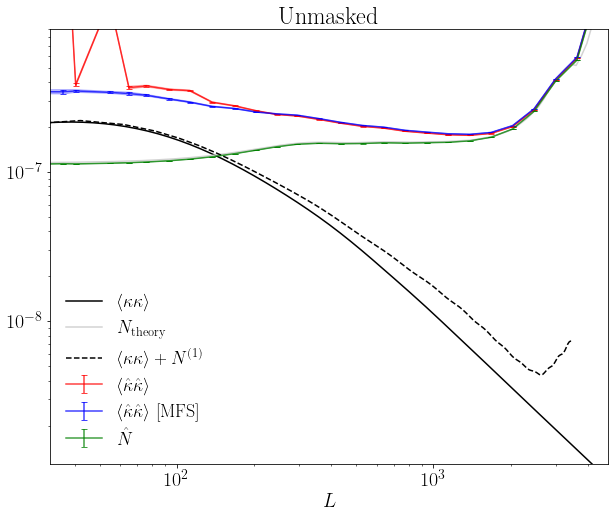

In [156]:
graph_from_keys_legacy([
    'QEQE',
    'QEQE MFS',
    'Nhat',
#     'QEQE-Ntheory',
#     'QEQE'
], offset=0.00, pN1=True)

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


(<Figure size 720x576 with 1 Axes>,
 <Axes: title={'center': 'Unmasked'}, xlabel='$L$'>)

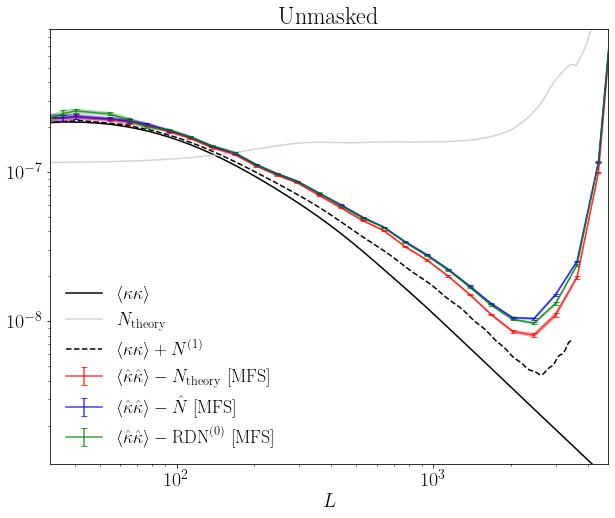

In [157]:
graph_from_keys_legacy([
    'QEQE-Ntheory MFS',
    'QEQE-Nhat MFS',
    'QEQE-RDN(0) MFS',
#     'QEQE-Ntheory',
#     'QEQE'
], offset=0.00, pN1=True)

500 (500, 3, 50)
500 (500, 3, 50)
1 (1, 3, 50)
1 (1, 3, 50)
500 (500, 3, 50)


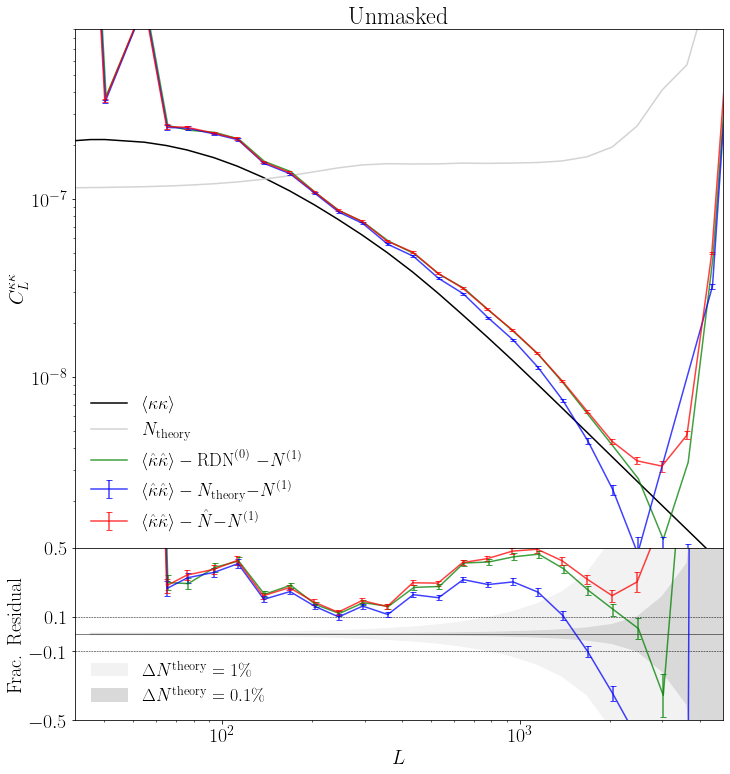

In [158]:
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Nhat',
    'QEQE-Ntheory',
    'QEQE-RDN(0)',
    
#     'GRF',
#     'QEQE-RDN(0)',
#     'QEQE-RDN(0) reduced',
#     'QEQE-RDN(0) quart',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.005, 
    pmNtheoryBand=True,
    pN1=True, 
    colors={'QEQE-Nhat':'red', 
            'QEQE-Nhat MFS':'orange',

            'QEQE-Ntheory':'blue', 
            'GRF': 'green',
#             'QEQE-RDN(0) quart':'#98f5b6', 
#             'QEQE-RDN(0) reduced':'#33d3a7',
            'QEQE-RDN(0)': 'green'
           },
    err_ylim=[-0.5,0.5],
     MCMC_n1=True,)

plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights_pMCMCN1_aniso.pdf', bbox_inches='tight')

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


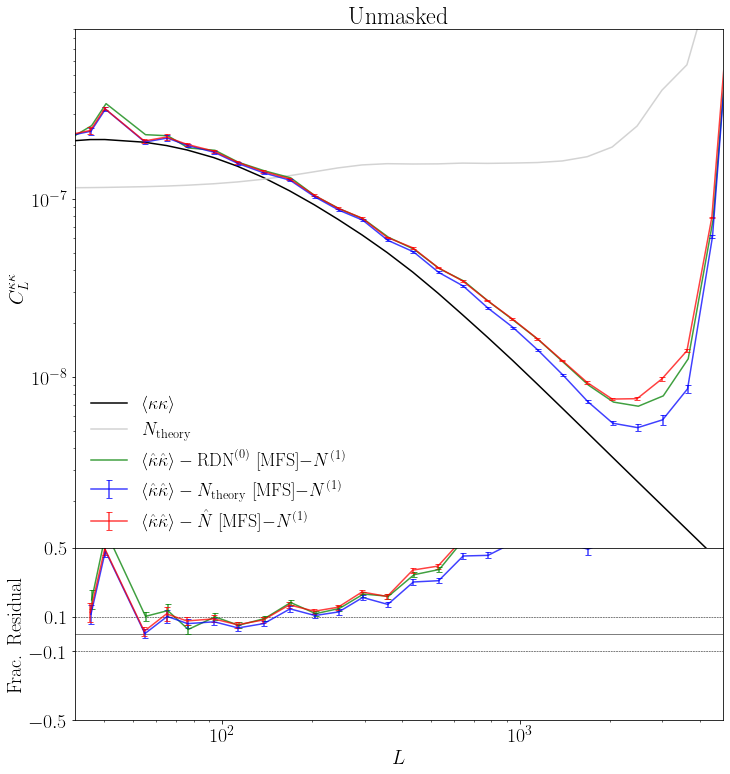

In [159]:
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Nhat MFS',
    'QEQE-Ntheory MFS',
    'QEQE-RDN(0) MFS',
    
#     'GRF',
#     'QEQE-RDN(0)',
#     'QEQE-RDN(0) reduced',
#     'QEQE-RDN(0) quart',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.005, 
    pmNtheoryBand=True,
    pN1=True, 
    colors={'QEQE-Nhat MFS':'red', 

            'QEQE-Ntheory MFS':'blue', 
            'GRF': 'green',
#             'QEQE-RDN(0) quart':'#98f5b6', 
#             'QEQE-RDN(0) reduced':'#33d3a7',
            'QEQE-RDN(0) MFS': 'green'
           },
    err_ylim=[-0.5,0.5],
     MCMC_n1=True,)

plt.savefig('figures/mNhat_vs_mNtheory_TgradT_weights_pMCMCN1_MFS_aniso.pdf', bbox_inches='tight')